# Forecasting 

![extrapolating](https://imgs.xkcd.com/comics/extrapolating.png)

In this lesson, we will practice forecasting using the following methods:  

- Last observed value  
- Simple average  
- Moving average  
- Holt's Linear Trend  
- Previous cycle  


______________________________


We will walk through steps from previous lessons to get the data ready to model

- Acquire data: prepare.acquire_store_data()  
- Prepare data: prepare.prep_store_data()  
- Split data: prepare.split_store_data()  

Then we will forecast and evaluate using each method. 

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import env

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

## Acquire

We will acquire the store-item-demand data for this lesson from the sql database. 

In [2]:
# define get_connection
df = env.get_tsa()

In [3]:
# assign query to variable 

In [4]:
# read sql query using pd.read_sql()

In [5]:
# take a peek
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,2013-01-02,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,3,2013-01-03,14,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
3,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,4,2013-01-04,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
4,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,5,2013-01-05,10,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


## Prepare


1. sale_date to datetime
2. sort values by date
3. set index
4. new field: dollars_sold = sale_amount * item_price
5. rename sale_amount to items_sold to make the two columns easier to understand what the data represents. 
6. resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)
7. remove leap days!

In [6]:
# sale_date to datetime
df = df.assign(ds= pd.to_datetime(df.sale_date))

In [7]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state,ds
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,2013-01-01
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,2013-01-02,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,2013-01-02
2,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,3,2013-01-03,14,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,2013-01-03
3,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,4,2013-01-04,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,2013-01-04
4,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,5,2013-01-05,10,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,2013-01-05


In [8]:
# sort values by date
df = df.sort_values('ds')

In [9]:
# create dollars_sold = sale_amount * item_price
df = df.assign(dollars_sold = df.sale_amount * df.item_price)

In [10]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state,ds,dollars_sold
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,2013-01-01,10.92
211816,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,2013-01-01,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,2013-01-01,30.16
832656,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,2013-01-01,32,8503 NW Military Hwy,78231,San Antonio,TX,2013-01-01,308.48
213642,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,2013-01-01,45,2118 Fredericksburg Rdj,78201,San Antonio,TX,2013-01-01,197.55
215468,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,2013-01-01,34,2118 Fredericksburg Rdj,78201,San Antonio,TX,2013-01-01,25.16


In [11]:
# create items_sold from sale_amount (rename)
df =df.assign(item_sold = df.sale_amount)

In [12]:
# resample daily, assumming dollars_sold and items_sold
df = df.groupby(['ds'])[['dollars_sold', 'item_sold']].sum()

In [13]:
# set index
#df.set_index('ds')

In [14]:
# gets you total sales, # renames the column, # this is like a resample by day
         
def prep_data(df):
    return df.assign(ds= pd.to_datetime(df.sale_date)).sort_values('ds').\
    assign(dollars_sold = df.sale_amount * df.item_price).\
    assign(item_sold = df.sale_amount).\
    df.groupby(['ds'])[['dollars_sold', 'item_sold']].sum() 

In [15]:
df.columns

Index(['dollars_sold', 'item_sold'], dtype='object')

In [16]:
df.head()

,dollars_sold,item_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


In [17]:
#df = prep_data(df)

In [18]:
# remove leap days by takin that day out of the index
df = df[df.index != '2016-02-29']

We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiple by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [19]:
df_size = len(df)
df_size

1825

In [20]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df)* .5)
train_size

912

In [21]:
# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)
validate_size

547

In [22]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df)- train_size - validate_size)
test_size

366

In [23]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

1459

In [24]:
# split into train, validation, test, # all rows until 912, 912 to 1459, # 1459 to (1825-1459)
train = df[: train_size] 
validate = df[train_size : validate_end_index] 
test = df[validate_end_index :]

In [25]:
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(df)

True

Does the first row of original df equate to the first row of train? 

In [26]:
# test the row starts
print(df.head(1)== train.head(1))

            dollars_sold  item_sold
ds                                 
2013-01-01          True       True


Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [27]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)]) # the results should be in order from one day to next

,dollars_sold,item_sold
ds,,
2015-07-01,164573.20,30703
2015-07-02,178036.64,33134


In [28]:
pd.concat([validate.tail(1), test.head(1)]) # the results should be in order from one day to next

,dollars_sold,item_sold
ds,,
2016-12-30,120033.64,22296
2016-12-31,128009.31,23792


Is the last row of test the same as the last row of our original dataframe? 

In [29]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,item_sold
ds,,
2017-12-31,140905.74,26420
2017-12-31,140905.74,26420


Let's plot our data first, viewing where the data is split into train, validate, and test. 

In [30]:
def plot_samples(target_var):
    ''' this function will plot the train, validate and test values for a single variable 
    '''
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)
    plt.show()

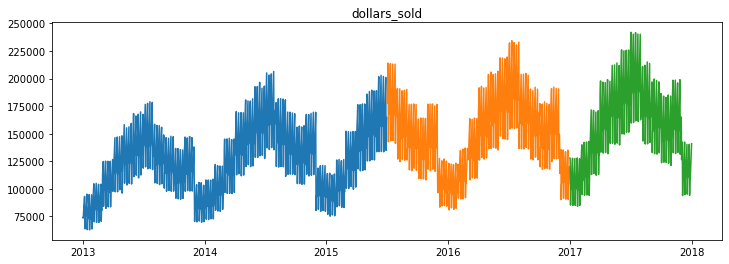

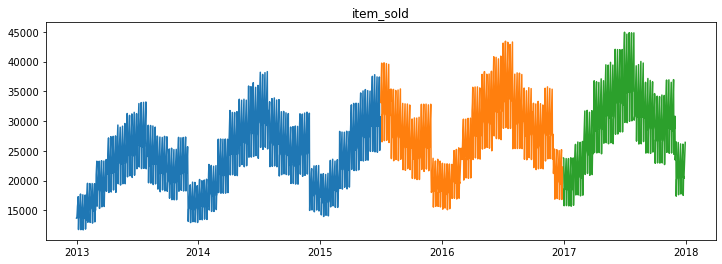

In [31]:
# plot the data points, color by train, validate, test
#col = 'dollars_sold'
for col in train.columns:
    plot_samples(col)

plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [32]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in the validate and the predicted values
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [33]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '--RMSE:  {: 0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [34]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var','rmse'])

In [35]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [36]:
# Define function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string,
    and run the evaluate() function to compute the rmse,
    and append to the dataframe a row with the model_type, target_var, and rmse. 
    It will return the new dataframe.
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forecast 

### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

In [37]:
# create var 'items' with last observed value
items = train['item_sold'][-1]
items

30703

In [38]:
# create dollars 'items' with last observed value
dollars = round(train['dollars_sold'][-1],2)
dollars

164573.2

In [39]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'item_sold': [items], 'dollars_sold': [dollars]}, index = validate.index)
yhat_df.head(2)

,item_sold,dollars_sold
ds,,
2015-07-02,30703,164573.2
2015-07-03,30703,164573.2


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

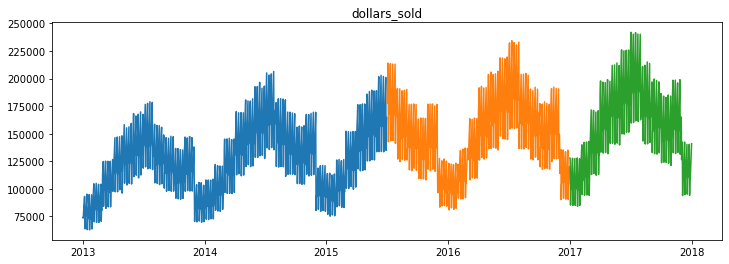

dollars_sold --RMSE:   35402.000000


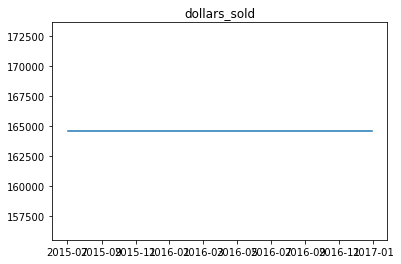

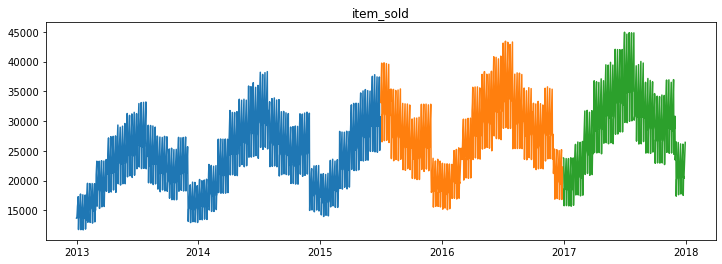

item_sold --RMSE:   6621.000000


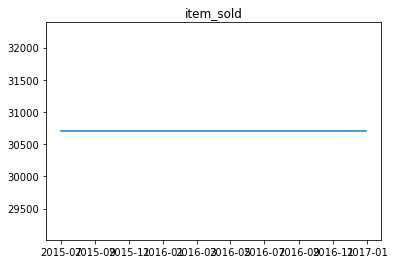

In [40]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [41]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

In [42]:
items = round(train['item_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

In [43]:
def make_predictions(items, dollars):
    yhat_df = pd.DataFrame({'item_sold': [items], 'dollars_sold':[dollars]}, index = validate.index)
    return yhat_df

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

In [44]:
yhat_df = make_predictions(items, dollars)
yhat_df

,item_sold,dollars_sold
ds,,
2015-07-02,23717.94,127517.85
2015-07-03,23717.94,127517.85
2015-07-04,23717.94,127517.85
2015-07-05,23717.94,127517.85
2015-07-06,23717.94,127517.85
...,...,...
2016-12-26,23717.94,127517.85
2016-12-27,23717.94,127517.85
2016-12-28,23717.94,127517.85


**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

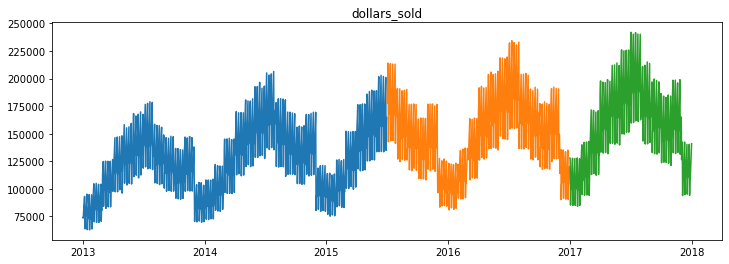

dollars_sold --RMSE:   39664.000000


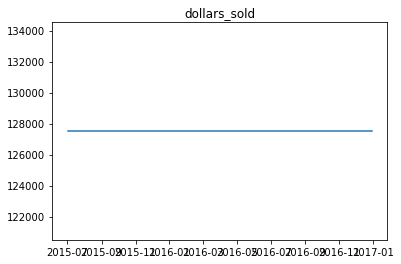

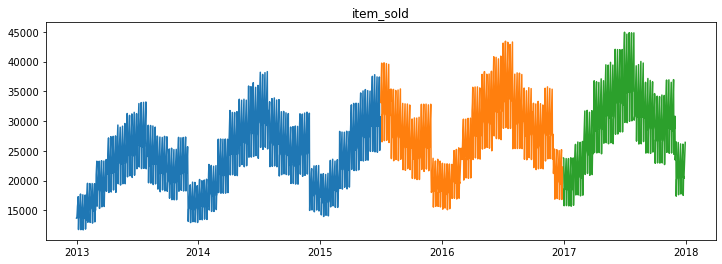

item_sold --RMSE:   7378.000000


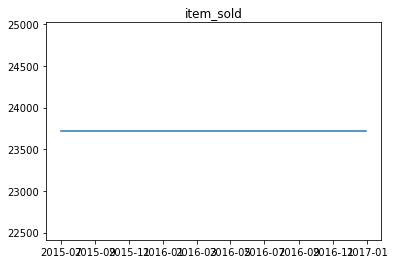

In [45]:
for col in train.columns:
    plot_and_eval(col)

### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

**Make Predictions**

In [46]:
yhat_df = make_predictions(items, dollars)

In [47]:
yhat_df.head(3)

,item_sold,dollars_sold
ds,,
2015-07-02,23717.94,127517.85
2015-07-03,23717.94,127517.85
2015-07-04,23717.94,127517.85


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

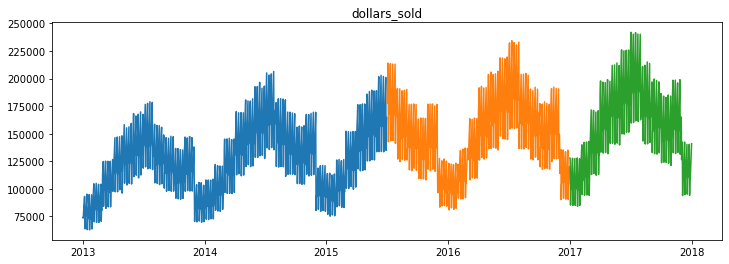

dollars_sold --RMSE:   39664.000000


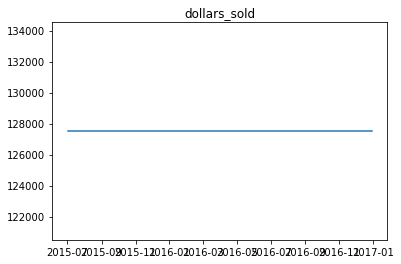

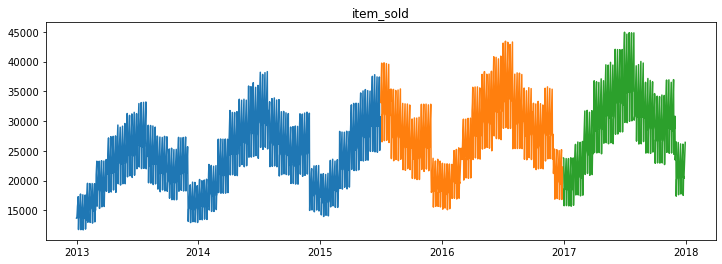

item_sold --RMSE:   7378.000000


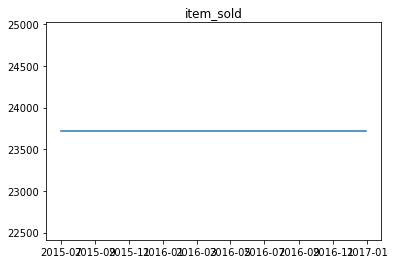

In [48]:
for col in train.columns:
    plot_and_eval(col)

In [49]:
period = 30
items = round(train['item_sold'].rolling(period).mean().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1])
items

31433

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [50]:
for col in train.columns:
    eval_df = append_eval_df(model_type="30d moving average", target_var = col)

In [51]:
# append the evaluation results to our eval_df for each target variable so we can 
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d moving average', target_var = col)

In [52]:
#eval_df[eval_df.target_var == 'dollars sold']
#eval_df[eval_df.target_vaar == 'item_sold']

#find the min value
eval_df_sort_values(by=['rmse'])

NameError: name 'eval_df_sort_values' is not defined

Let's try out several other values for periods:

In [53]:
period = 200
items = round(train['item_sold'].rolling(period).mean().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1])
items

24452

In [54]:
period = 15
items = round(train['item_sold'].rolling(period).mean().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)
yhat_df = make_predictions(items, dollars)
for col in train.columns:
    eval_df = append_eval_df(model_type="15d moving average", target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,item_sold,6621.0
2,30d moving average,dollars_sold,39664.0
3,30d moving average,item_sold,7378.0
4,30d moving average,dollars_sold,39664.0
5,30d moving average,item_sold,7378.0
6,15d moving average,dollars_sold,37441.0
7,15d moving average,item_sold,6958.0


Which is best so far? 

In [55]:
# get the min rmse for each variable
eval_df.sort_values(by=['rmse']).groupby('target_var').first()

,model_type,rmse
target_var,,
dollars_sold,last_observed_value,35402.0
item_sold,last_observed_value,6621.0


In [56]:
# filter only the rows that match those rmse to find out 
# which models are best thus far


### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 


**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target. 

dollars_sold 



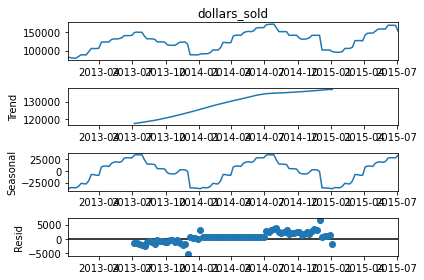

item_sold 



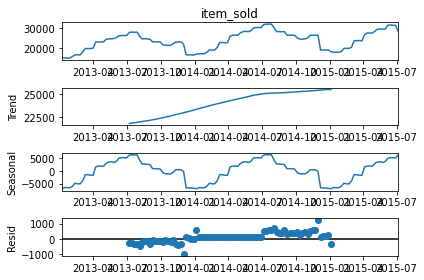

In [57]:
import statsmodels.api as sm

for col in train.columns:
    print(col, '\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)

In [58]:
for col in train.columns:
    # Making the model
    model = Holt(train[col], exponential = False)
    
    # Fitting the model
    model = model.fit(smoothing_level = .5, smoothing_slope = .5, optimized = False)
    
    # Making predictions 
    yhat = model.predict(start = validate.index[0], end = validate.index[-1])
    
    yhat_df[col] = round(yhat, 0)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [59]:
# for col in train.columns:
#     model = Holt(train['item_sold'], exponential = False)

#     model = model.fit(smoothing_level = .5, 
#                  smoothing_slope = .5,
#                  optimized = False)
#     # predict/forecast providing the start and end dates
#     yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])
    
#     yhat_df[col] = round(yhat, 2)

**Plot Actual vs. Predicted Values**

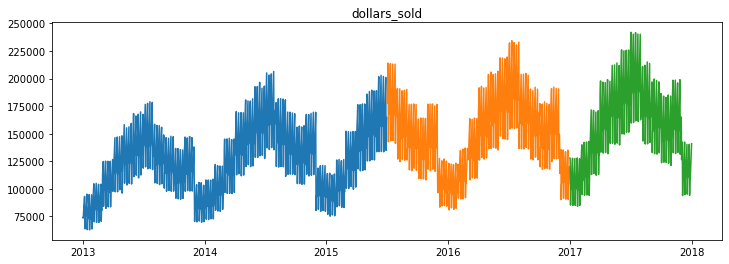

dollars_sold --RMSE:   1581535.000000


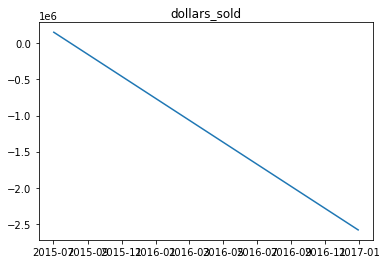

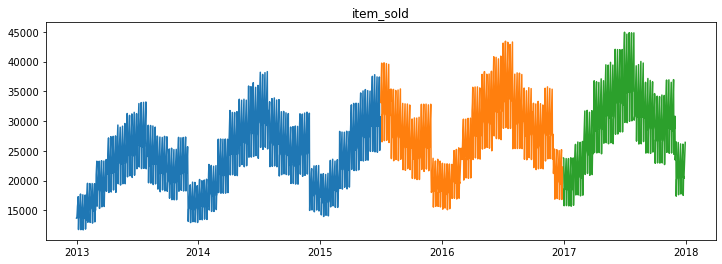

item_sold --RMSE:   294543.000000


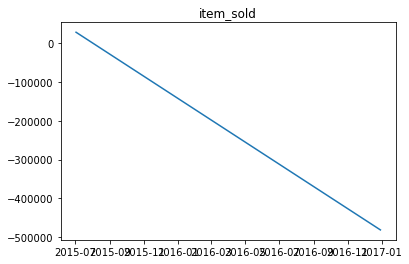

In [60]:
for col in train.columns:
        eval_df = append_eval_df(model_type = 'Holts', target_var = col)
        plot_and_eval(target_var = col)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


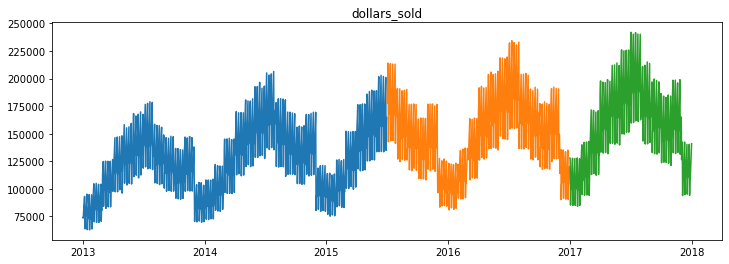

dollars_sold --RMSE:   34700.000000


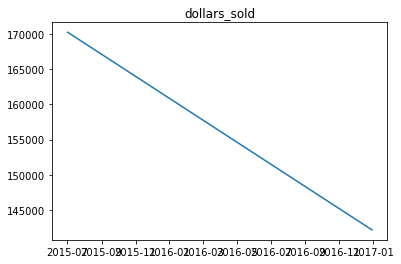

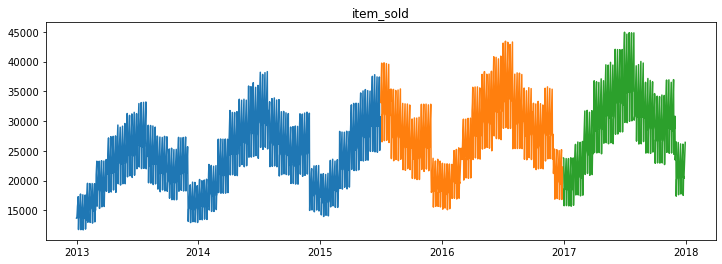

item_sold --RMSE:   6464.000000


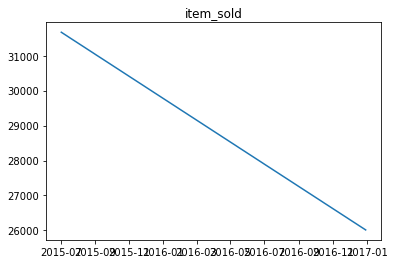

In [61]:
for col in train.columns:
    # Making the model
    model = Holt(train[col], exponential = False)
    
    # Fitting the model
    model = model.fit(smoothing_level = .1, smoothing_slope = .1, optimized = False)
    
    # Making predictions 
    yhat = model.predict(start = validate.index[0], end = validate.index[-1])
    
    yhat_df[col] = round(yhat, 0)
    
for col in train.columns:
        eval_df = append_eval_df(model_type = 'Holts L=.1 S=.1', target_var = col)
        plot_and_eval(target_var = col)

In [62]:
yhat_df.head()

,item_sold,dollars_sold
ds,,
2015-07-02,31671.0,170252.0
2015-07-03,31661.0,170200.0
2015-07-04,31650.0,170149.0
2015-07-05,31640.0,170097.0
2015-07-06,31630.0,170046.0


**Evaluate**

In [63]:
# eval_df = eval_df[eval_df.model_type != 'Holts']

In [64]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,item_sold,6621.0
2,30d moving average,dollars_sold,39664.0
3,30d moving average,item_sold,7378.0
4,30d moving average,dollars_sold,39664.0
5,30d moving average,item_sold,7378.0
6,15d moving average,dollars_sold,37441.0
7,15d moving average,item_sold,6958.0
8,Holts,dollars_sold,1581535.0
9,Holts,item_sold,294543.0


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [65]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [66]:
# year difference
train.diff(365).mean()

dollars_sold    11751.250493
item_sold        2185.813699
dtype: float64

**Make Predictions**

In [67]:
# take the values for each day in 2015 and add the average year over year(yoy)(y/y)
yhat_df = train['2015'] + train.diff(365).mean()

In [68]:
# set yhat_df to index of validate

In [69]:
yhat_df = yhat_df.set_index(validate.index)


In [70]:
eval_df.sort_values('rmse').groupby('target_var').first()

,model_type,rmse
target_var,,
dollars_sold,Holts L=.1 S=.1,34700.0
item_sold,Holts L=.1 S=.1,6464.0


In [71]:
# set yhat_df to index of validate
yhat_df = yhat_df.set_index(validate.index)


In [72]:
# set yhat_df to index of validate
yhat_df.head()

,dollars_sold,item_sold
ds,,
2016-01-01,104337.620493,19411.813699
2016-01-02,112870.770493,20904.813699
2016-01-03,118245.300493,21983.813699
2016-01-04,125496.760493,23286.813699
2016-01-05,88551.940493,16420.813699


**Plot and Evaluate**

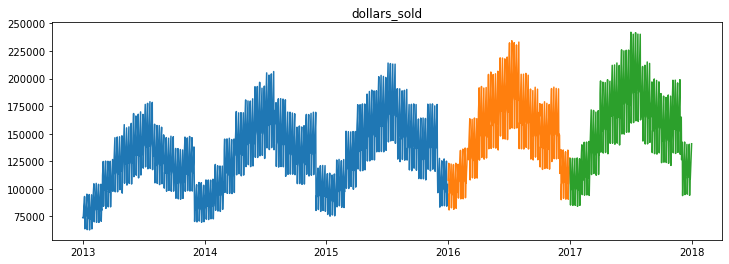

dollars_sold --RMSE:   28087.000000


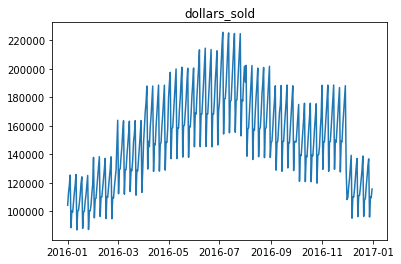

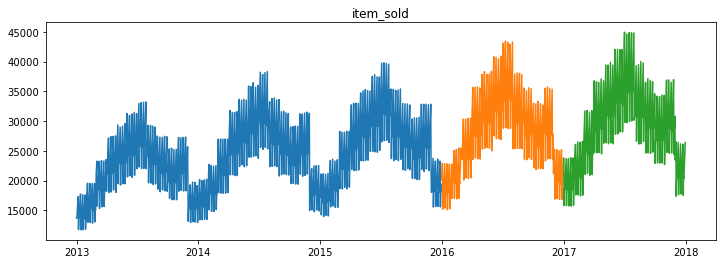

item_sold --RMSE:   5223.000000


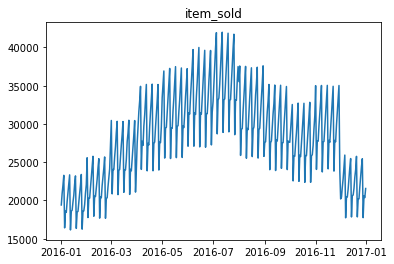

In [73]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'yoy-diff', target_var = col)
    plot_and_eval(target_var = col)

In [74]:
compare_df = pd.concat([yhat_df.item_sold, validate.item_sold], axis = 1)
compare_df.columns = ['yhat_items', 'actual_items']
compare_df['error'] = compare_df.actual_items - compare_df.yhat_items
compare_df['squared_error'] = compare_df.error * compare_df.error
#compare_df[compare_df.squared_error.mean()]
compare_df

,yhat_items,actual_items,error,squared_error
ds,,,,
2016-01-01,19411.813699,20158,746.186301,5.567940e+05
2016-01-02,20904.813699,21280,375.186301,1.407648e+05
2016-01-03,21983.813699,22911,927.186301,8.596744e+05
2016-01-04,23286.813699,15199,-8087.813699,6.541273e+07
2016-01-05,16420.813699,17806,1385.186301,1.918741e+06
...,...,...,...,...
2016-12-27,25453.813699,19341,-6112.813699,3.736649e+07
2016-12-28,17754.813699,19560,1805.186301,3.258698e+06
2016-12-29,20588.813699,21111,522.186301,2.726785e+05


## Conclusion

Which model did the best? 

In [75]:
# get the min rmse for each variable


# filter only the rows that match those rmse to find out 
# which models are best thus far


Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [76]:
# must use same parameters we used from train
yhat_ = validate + train.diff(365).mean()

# set index to that of test
yhat_df.index = test.index


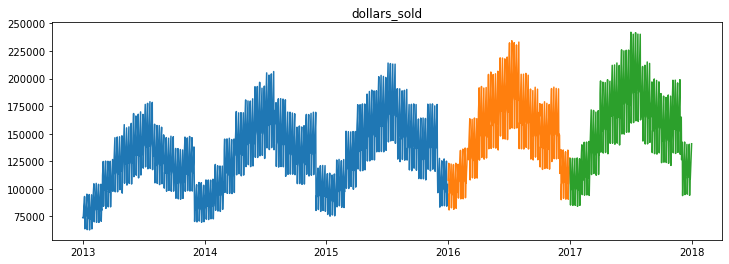

dollars_sold --RMSE:   28087.000000


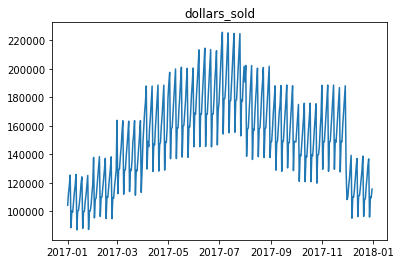

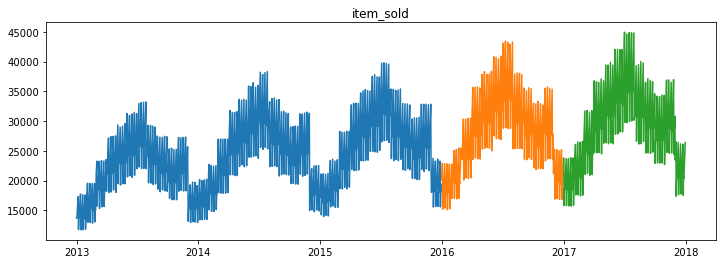

item_sold --RMSE:   5223.000000


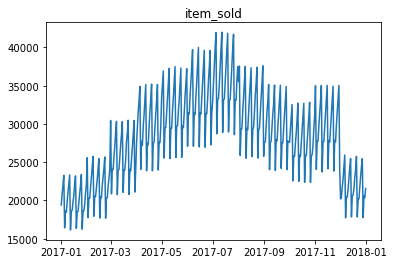

In [77]:
for col in train.columns:
    plot_and_eval(col)
    append_eval_df(model_type = 'yoy-diff-test', target_var = col)

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.